In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import seaborn as sns

def generate_var_data(n1, n2, sigma, k, phi, size=2):
    n = n1 + n2
    data = np.zeros((n, size))
    eps1 = np.random.normal(0, sigma, size=(n1, size))
    eps2 = np.random.normal(0, k * sigma, size=(n2, size))
    eps = np.vstack([eps1, eps2])
    for t in range(1, n):
        data[t] = phi @ data[t-1] + eps[t]
    return data


def granger_test_with_hc(data, n_lags, hc_type):
    y = data[:, 0] 
    x = data[:, 1] 


    lags = np.column_stack([np.roll(x, lag) for lag in range(1, n_lags + 1)])
    lags = lags[n_lags:]  
    y = y[n_lags:]

    X = add_constant(lags)
    model = OLS(y, X).fit(cov_type=hc_type)
    return model.f_pvalue

def simulate_granger_power(n1, n2, sigma, k, phi, n_lags=1, n_simulations=100):
    hc0_significant_count = 0
    hc3_significant_count = 0

    for _ in range(n_simulations):
        data = generate_var_data(n1, n2, sigma, k, phi)

        hc0_p_value = granger_test_with_hc(data, n_lags, hc_type='HC0')
        hc3_p_value = granger_test_with_hc(data, n_lags, hc_type='HC3')

        if hc0_p_value < 0.05:
            hc0_significant_count += 1
        if hc3_p_value < 0.05:
            hc3_significant_count += 1

    return hc0_significant_count / n_simulations, hc3_significant_count / n_simulations


n1_values = [50, 100, 1000]
n2_values = [50, 100, 1000]
sigma = 1.0
k_values = [1.5, 2.0, 3.0]
phi_values = [np.eye(2) * 0.5, np.eye(2) * 0.8]

results = []

for n1 in n1_values:
    for n2 in n2_values:
        for k in k_values:
            for phi in phi_values:
                hc0_power, hc3_power = simulate_granger_power(n1, n2, sigma, k, phi)
                results.append((n1, n2, k, np.diag(phi)[0], hc0_power, hc3_power))

df = pd.DataFrame(results, columns=['n1', 'n2', 'k', 'phi', 'HC0_power', 'HC3_power'])
print(df)

      n1    n2    k  phi  HC0_power  HC3_power
0     50    50  1.5  0.5       0.14       0.13
1     50    50  1.5  0.8       0.27       0.25
2     50    50  2.0  0.5       0.20       0.18
3     50    50  2.0  0.8       0.44       0.42
4     50    50  3.0  0.5       0.24       0.22
5     50    50  3.0  0.8       0.31       0.30
6     50   100  1.5  0.5       0.21       0.20
7     50   100  1.5  0.8       0.39       0.37
8     50   100  2.0  0.5       0.13       0.13
9     50   100  2.0  0.8       0.35       0.33
10    50   100  3.0  0.5       0.15       0.14
11    50   100  3.0  0.8       0.38       0.37
12    50  1000  1.5  0.5       0.13       0.13
13    50  1000  1.5  0.8       0.36       0.36
14    50  1000  2.0  0.5       0.12       0.12
15    50  1000  2.0  0.8       0.32       0.32
16    50  1000  3.0  0.5       0.07       0.07
17    50  1000  3.0  0.8       0.35       0.35
18   100    50  1.5  0.5       0.15       0.14
19   100    50  1.5  0.8       0.43       0.43
20   100    5

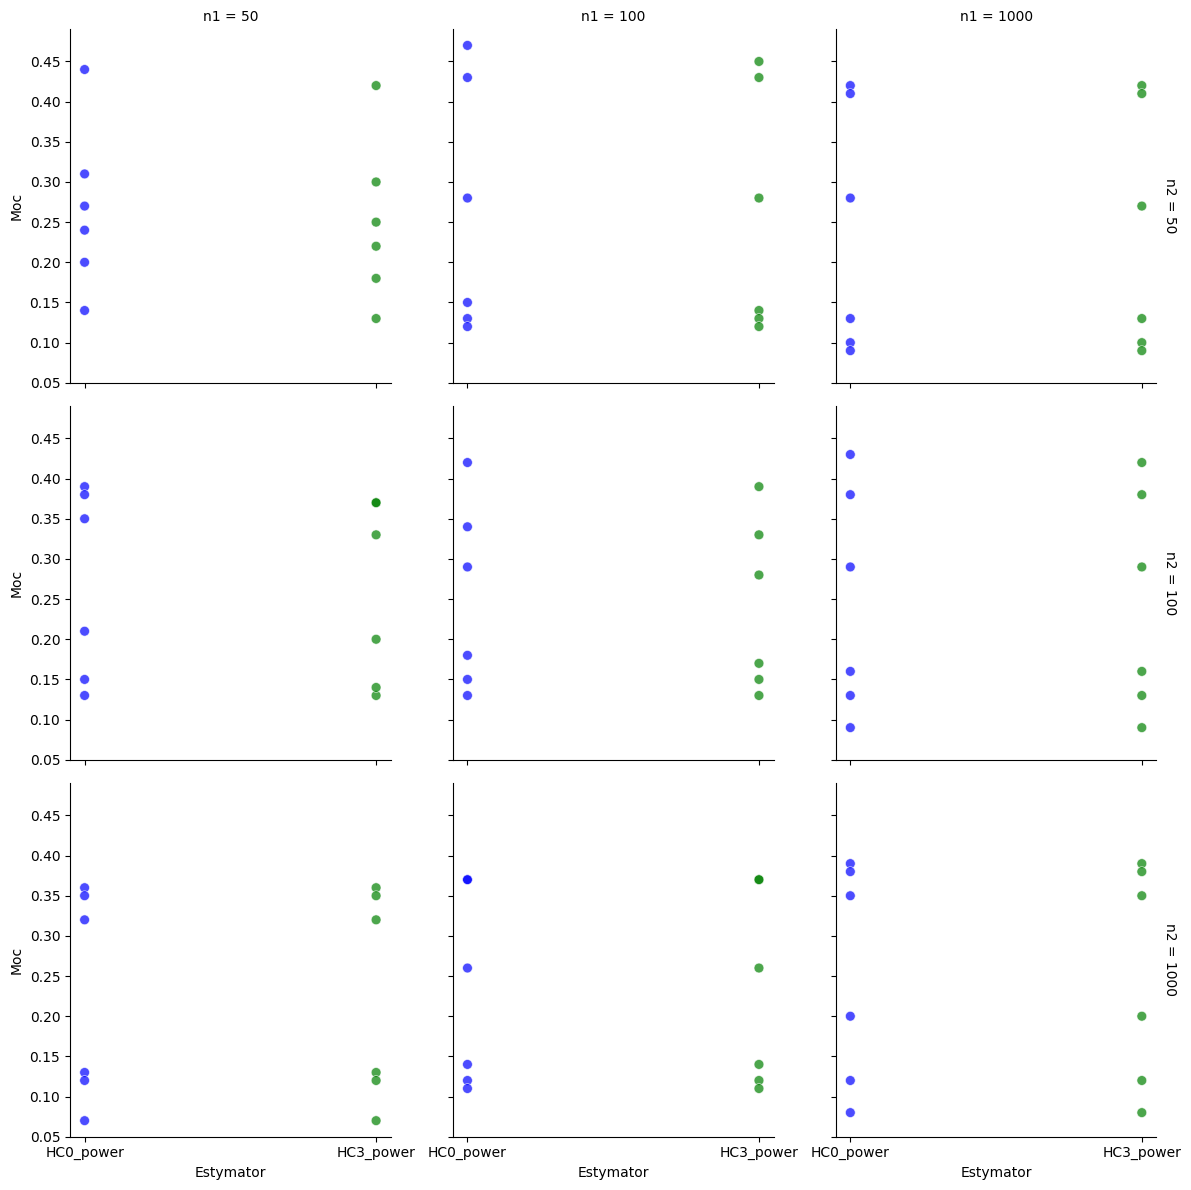

In [29]:
df_melted = df.melt(id_vars=["n1", "n2"], value_vars=["HC0_power", "HC3_power"],
                    var_name="Estymator", value_name="Moc")

g = sns.FacetGrid(df_melted, col="n1", row="n2", margin_titles=True, height=4, aspect=1)

g.map(sns.scatterplot, "Estymator", "Moc", data=df_melted, hue="Estymator", palette={"HC0_power": "blue", "HC3_power": "green"}, s=50, alpha=0.7)

g.set_titles(col_template="n1 = {col_name}", row_template="n2 = {row_name}")
plt.show()

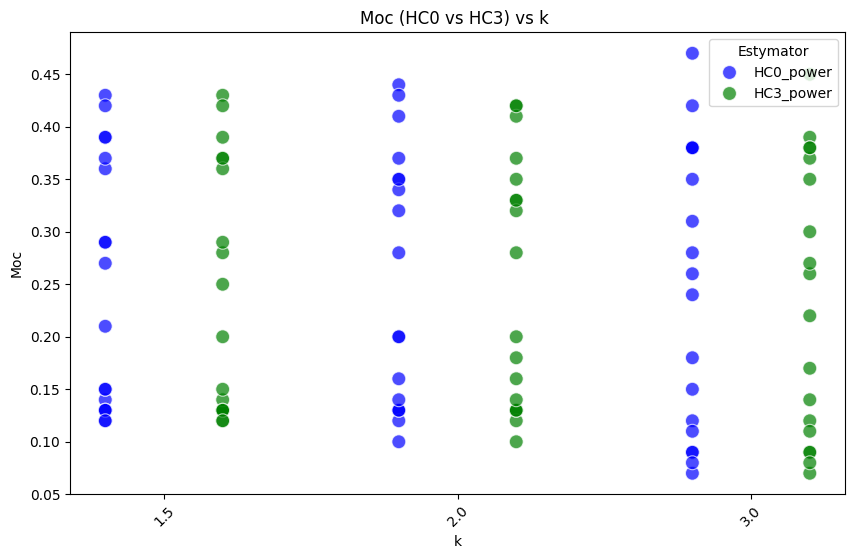

In [13]:
df_melted = df.melt(id_vars=["n1", "n2", "k"], value_vars=["HC0_power", "HC3_power"],
                    var_name="Estymator", value_name="Moc")

df_melted['k'] = df_melted['k'].astype(str)

df_melted['Offset_k'] = df_melted['k']

df_melted['Offset_k'] = df_melted['Offset_k'].astype('category')
df_melted['Offset_k'] = df_melted['Offset_k'].cat.codes + (df_melted['Estymator'].map({'HC0_power': -0.2, 'HC3_power': 0.2}))

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_melted, x="Offset_k", y="Moc", hue="Estymator", palette={"HC0_power": "blue", "HC3_power": "green"}, s=100, alpha=0.7)

plt.xlabel('k')
plt.ylabel('Moc')
plt.title('Moc (HC0 vs HC3) vs k ')

plt.xticks(ticks=np.arange(len(df_melted['k'].unique())), labels=df_melted['k'].unique(), rotation=45)

plt.legend(title='Estymator')
plt.show()

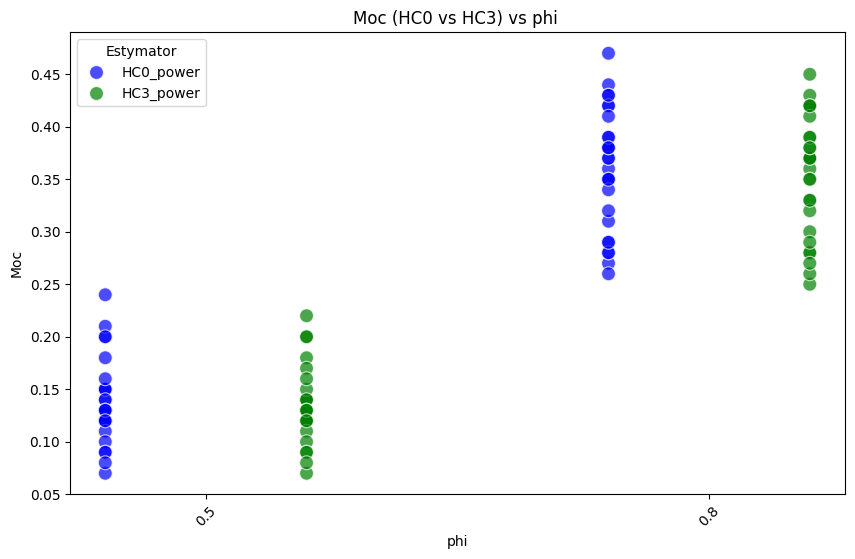

In [12]:
df_melted = df.melt(id_vars=["n1", "n2", "phi"], value_vars=["HC0_power", "HC3_power"],
                    var_name="Estymator", value_name="Moc")

df_melted['phi'] = df_melted['phi'].astype(str)

df_melted['Offset_phi'] = df_melted['phi']

df_melted['Offset_phi'] = df_melted['Offset_phi'].astype('category')
df_melted['Offset_phi'] = df_melted['Offset_phi'].cat.codes + (df_melted['Estymator'].map({'HC0_power': -0.2, 'HC3_power': 0.2}))

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_melted, x="Offset_phi", y="Moc", hue="Estymator", palette={"HC0_power": "blue", "HC3_power": "green"}, s=100, alpha=0.7)

plt.xlabel('phi')
plt.ylabel('Moc')
plt.title('Moc (HC0 vs HC3) vs phi ')

plt.xticks(ticks=np.arange(len(df_melted['phi'].unique())), labels=df_melted['phi'].unique(), rotation=45)

plt.legend(title='Estymator')
plt.show()
